# Détecteur de stéréotypes


In [5]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [6]:
# Imports
import json
import os
import re

import matplotlib.pyplot as plt
import pandas as pd
from dotenv import load_dotenv
from mistralai import Mistral
from tqdm.auto import tqdm
from pyfonts import load_google_font
from aquarel import load_theme

load_dotenv()
tqdm.pandas()

## Importation et simplification des données


In [3]:
df = pd.read_csv("./dataset/rtbfCorpus.csv", sep="|", encoding="utf-8")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767204 entries, 0 to 767203
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 767204 non-null  int64 
 1   pub_date           767204 non-null  object
 2   feed               767204 non-null  object
 3   category           759930 non-null  object
 4   keyword            644449 non-null  object
 5   signature          763736 non-null  object
 6   title              767202 non-null  object
 7   text_html          767204 non-null  object
 8   text_cleaned       767204 non-null  object
 9   test_preprocessed  767201 non-null  object
dtypes: int64(1), object(9)
memory usage: 58.5+ MB


In [4]:
# Filter the DataFrame for the "MONDE" category
df_monde = df[df["category"] == "MONDE"]
df_monde.info()

<class 'pandas.core.frame.DataFrame'>
Index: 92188 entries, 130 to 767150
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 92188 non-null  int64 
 1   pub_date           92188 non-null  object
 2   feed               92188 non-null  object
 3   category           92188 non-null  object
 4   keyword            76601 non-null  object
 5   signature          92188 non-null  object
 6   title              92188 non-null  object
 7   text_html          92188 non-null  object
 8   text_cleaned       92188 non-null  object
 9   test_preprocessed  92188 non-null  object
dtypes: int64(1), object(9)
memory usage: 7.7+ MB


In [5]:
distinct_keywords = df_monde["keyword"].unique()
distinct_keywords

array([nan, 'AMERIQUE DU SUD', 'ASIE', 'DEFENSE', 'EUROPE',
       'MOYEN ORIENT', 'AFRIQUE', 'POLITIQUE', 'DIVERS',
       'AMERIQUE DU NORD', 'JUSTICE', 'ENERGIE', 'DROGUES',
       'AMERIQUE CENTRALE', 'AGRICULTURE', 'RELIGION', 'CONSOMMATION',
       'FAITS DIVERS', 'ENVIRONNEMENT', 'CATASTROPHES', 'IMMIGRATION',
       'MOBILITE', 'BEAUX ARTS', 'OCEANIE', 'SANTE', 'LOISIRS',
       'JEUNESSE', 'PEOPLE', 'AERONAUTIQUE', 'INTERNET', 'ENSEIGNEMENT',
       'TERRORISME', 'CATASTROPHE', 'ESPACE', 'CINEMA', 'ECONOMIE',
       'LITTERATURE', 'SYNDICALISME', 'MUSIQUE', 'INSOLITE', 'SCIENCES',
       'CONFLITS', 'TECHNOLOGIE', 'REGION DE BRUXELLES', 'EMPLOI',
       'ENTREPRISES', 'MONARCHIE', 'AUTOMOBILE', 'MER', 'DEVISES',
       'NAMUR', 'SPECTACLES'], dtype=object)

In [6]:
keywords_to_filter_out = [
    "AMERIQUE DU SUD",
    "ASIE",
    "AMERIQUE CENTRALE",
    "AMERIQUE DU NORD",
    "REGION DE BRUXELLES",
    "SPECTACLES",
    "OCEANIE",
    "NAMUR",
]
mask = df_monde["keyword"].isin(keywords_to_filter_out)
df_monde_restreint = df_monde[~mask]

## Sampling pour protoyper


In [7]:
sr = df_monde_restreint
sr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77519 entries, 130 to 767150
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 77519 non-null  int64 
 1   pub_date           77519 non-null  object
 2   feed               77519 non-null  object
 3   category           77519 non-null  object
 4   keyword            61932 non-null  object
 5   signature          77519 non-null  object
 6   title              77519 non-null  object
 7   text_html          77519 non-null  object
 8   text_cleaned       77519 non-null  object
 9   test_preprocessed  77519 non-null  object
dtypes: int64(1), object(9)
memory usage: 6.5+ MB


## Stéréotypes


In [8]:
stereotypes = {
    "assad_vs_daech": {
        "id": "assad_vs_daech",
        "canonical_form": "Le conflit syrien se résume à un duel : soit Assad, soit Daech.",
        "description": "Stéréotype central : Assad serait le seul rempart contre Daech. Cette vision binaire efface la pluralité des acteurs (opposition modérée, groupes locaux, factions civiles, Kurdes, islamistes non jihadistes).Elle est souvent mobilisée pour justifier le maintien du régime.",
        "variants": [
            "C'est Assad ou Daech",
            "Assad est le seul rempart contre Daech",
            "Sans Assad, Daech prendra le pouvoir",
            "Assad ou les terroristes",
            "Assad ou le chaos",
            "Assad ou les islamistes",
            "Il n'y a pas d'alternative à Assad",
            "Entre Assad et Daech il n'y a rien",
            "Le régime protège la Syrie du terrorisme",
        ],
        "mandatory_keywords": [
            "Syrie",
            "Assad",
        ],
        "keywords": [
            "Syrie",
            "Assad",
            "Daech",
            "État islamique",
            "terroristes",
            "rempart",
            "moindre mal",
            "pas d'alternative",
            "chaos",
            "stabilité",
            "extrémistes",
        ],
        "sub_stereotypes": [
            {
                "id": "opposition_islamiste",
                "canonical_form": "L'opposition syrienne est fondamentalement islamiste ou jihadiste.",
                "description": "Idée reçue : l'opposition est décrite comme un bloc islamiste, effaçant sa diversité (civile, laïque, minoritaire, armée non jihadiste). Cette vision s'appuie souvent sur des références au Friday protests, au takbîr, ou à l'influence des Frères musulmans.",
                "variants": [
                    "L'opposition est islamiste",
                    "Les rebelles sont des islamistes",
                    "Les opposants sont tous extrémistes",
                    "Les rebelles syriens sont des jihadistes",
                    "L'opposition est dominée par les islamistes",
                ],
                "keywords": [
                    "opposition",
                    "rebelles",
                    "islamistes",
                    "extrémistes",
                    "Frères musulmans",
                    "takbir",
                    "mosquée",
                ],
            },
            {
                "id": "opposition_absente",
                "canonical_form": "Il n'existe pas d'opposition syrienne crédible ou significative.",
                "description": "Idée reçue : la révolution syrienne n'a pas produit d'opposition structurée. Cela nie l'existence des comités locaux, de l'Armée syrienne libre, des institutions civiles locales et des cadres politiques du CNS.",
                "variants": [
                    "Il n'y a pas d'opposition crédible",
                    "Les rebelles sont désorganisés",
                    "Il n'y a pas d'alternative politique",
                    "L'opposition syrienne est inexistante",
                    "Personne pour remplacer Assad",
                ],
                "keywords": [
                    "opposition",
                    "rebelles",
                    "ASL",
                    "alternatives",
                    "absence d'opposition",
                    "CNS",
                    "pas crédible",
                ],
            },
            {
                "id": "revolution_confessionnelle",
                "canonical_form": "La révolution syrienne est un soulèvement sunnite confessionnel.",
                "description": "Stéréotype : le conflit syrien serait avant tout confessionnel ou communautaire. En réalité, les revendications initiales étaient politiques, et que des figures minoritaires participèrent au soulèvement.",
                "variants": [
                    "Les sunnites veulent renverser les minorités",
                    "La révolution est confessionnelle",
                    "Conflit sunnites contre alaouites",
                ],
                "keywords": [
                    "sunnites",
                    "alaouites",
                    "communautaire",
                    "confessionnel",
                    "minorités",
                    "sectaire",
                ],
            },
        ],
    },
}

## Rôle

Tu es un assistant qui analyse des articles de journaux pour détecter un certain type de stéréotype / idée reçue concernant la Syrie.

Stéréotype à détecter (ID: assad_vs_daech) : **"Le conflit syrien se résume à un duel : soit Assad, soit Daech."**
Description: Assad serait le seul rempart contre Daech. Cette vision binaire efface la pluralité des acteurs (opposition modérée, groupes locaux, factions civiles, Kurdes, islamistes non jihadistes).Elle est souvent mobilisée pour justifier le maintien du régime.

De ce stéréotype découlent d'autres idées reçues analogues:

- **"L'opposition syrienne est fondamentalement islamiste ou jihadiste."** : l'opposition est décrite comme un bloc islamiste, effaçant sa diversité (civile, laïque, minoritaire, armée non jihadiste). Cette vision s'appuie souvent sur des références au Friday protests, au takbîr, ou à l'influence des Frères musulmans.
- **"Il n'existe pas d'opposition syrienne crédible ou significative."** : la révolution syrienne n'a pas produit d'opposition structurée. Cela nie l'existence des comités locaux, de l'Armée syrienne libre, des institutions civiles locales et des cadres politiques du CNS.
- **La révolution syrienne est un soulèvement sunnite confessionnel.** : le conflit syrien serait avant tout confessionnel ou communautaire. En réalité, les revendications initiales étaient politiques, et que des figures minoritaires participèrent au soulèvement.

Variantes possibles de ce stéréotype :

- "C'est Assad ou Daech"
- "Assad est le seul rempart contre Daech"
- "Sans Assad, Daech prendra le pouvoir"
- "Assad ou les terroristes"
- "Assad ou le chaos"
- "Assad ou les islamistes"
- "Il n'y a pas d'alternative à Assad"
- "Entre Assad et Daech il n'y a rien"
- "Le régime protège la Syrie du terrorisme"

## Tâche

Je te donne un article de journal. Tu dois l'analyser et identifier si le stéréotype ci-dessus est présent, si oui sous quelle forme, et pourquoi.
Réponds STRICTEMENT au format JSON suivant (sans texte additionnel) :

```json
{
  "stereotype_id": "assad_vs_daech",
  "present": "yes" | "no" | "uncertain",
  "mode": "reproduit" | "nuancé" | "critiqué" | "non_pertinent",
  "intensite": "évoqué" | "présent" | "dominant" | "omniprésent" | "non_pertinent",
  "resume": "Très court résumé du contenu de l'article. Trois phrases maximum.",
  "justification": "Courte argumentation quant à la présence du stéréotype dans l'article. Laisser vide si le stéréotype est absent.",
}
```


In [ ]:
mandatory_keywords = stereotypes["assad_vs_daech"]["mandatory_keywords"]


def contains_all_mandatory(text, keywords):
    if not isinstance(text, str):
        return False
    for kw in keywords:
        if not re.search(r"\b" + re.escape(kw) + r"\b", text, flags=re.IGNORECASE):
            return False
    return True


sr_keywords = sr[
    sr["text_cleaned"].progress_apply(
        lambda t: contains_all_mandatory(t, mandatory_keywords)
    )
]
sr_keywords.info()

  0%|          | 0/77519 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Index: 2461 entries, 1952 to 766787
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 2461 non-null   int64 
 1   pub_date           2461 non-null   object
 2   feed               2461 non-null   object
 3   category           2461 non-null   object
 4   keyword            2419 non-null   object
 5   signature          2461 non-null   object
 6   title              2461 non-null   object
 7   text_html          2461 non-null   object
 8   text_cleaned       2461 non-null   object
 9   test_preprocessed  2461 non-null   object
dtypes: int64(1), object(9)
memory usage: 211.5+ KB


In [10]:
def count_keywords(text, keywords):
    count = 0
    for kw in keywords:
        # recherche de mots entiers \b...\b (très important)
        if re.search(r"\b" + re.escape(kw) + r"\b", text, flags=re.IGNORECASE):
            count += 1
    return count

In [11]:
all_keywords = set()

for word in stereotypes["assad_vs_daech"]["keywords"]:
    all_keywords.add(word.lower())

for sub_stereotype in stereotypes["assad_vs_daech"]["sub_stereotypes"]:
    for word in sub_stereotype["keywords"]:
        all_keywords.add(word.lower())

sr_keywords["keyword_count"] = sr_keywords["text_cleaned"].progress_apply(
    lambda t: count_keywords(t, all_keywords)
)


  0%|          | 0/2461 [00:00<?, ?it/s]

/tmp/ipykernel_14302/699132076.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["keyword_count"] = sr_keywords["text_cleaned"].progress_apply(


In [117]:
MIN_KEYWORDS = 3
sr_ready = sr_keywords[sr_keywords["keyword_count"] == MIN_KEYWORDS]
sr_ready.info()

<class 'pandas.core.frame.DataFrame'>
Index: 731 entries, 2250 to 765780
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 731 non-null    int64 
 1   pub_date           731 non-null    object
 2   feed               731 non-null    object
 3   category           731 non-null    object
 4   keyword            715 non-null    object
 5   signature          731 non-null    object
 6   title              731 non-null    object
 7   text_html          731 non-null    object
 8   text_cleaned       731 non-null    object
 9   test_preprocessed  731 non-null    object
 10  keyword_count      731 non-null    int64 
dtypes: int64(2), object(9)
memory usage: 68.5+ KB


In [ ]:
def load_and_filter_new_rows(
    prev_path: str = "./output/sr_ready_with_stereotype_analysis_6_min_keywords.pkl",
    current_df=None,
    id_col: str = "id",
    save_path: str | None = None,
):
    """
    Load a previous dataframe (pickle) and return only the rows from current_df
    that are not present in the previous dataframe, comparing by `id_col`.

    Returns a tuple: (new_df, prev_df_or_None).
    If the previous pickle does not exist, returns a copy of current_df and prev_df is None.
    If save_path is provided, the resulting new_df is saved as a pickle there.

    Parameters:
    - prev_path: path to the previous pickle
    - current_df: the current dataframe (sr_ready)
    - id_col: column used to identify rows (default "id")
    - save_path: optional path to save the resulting new dataframe
    """
    if current_df is None:
        raise ValueError("current_df must be provided (e.g. sr_ready)")

    if id_col not in current_df.columns:
        raise KeyError(f"current_df does not contain id column '{id_col}'")

    prev_df = None
    if not os.path.exists(prev_path):
        new_df = current_df.copy()
    else:
        prev_df = pd.read_pickle(prev_path)
        if id_col not in prev_df.columns:
            raise KeyError(f"previous dataframe does not contain id column '{id_col}'")
        prev_ids = set(prev_df[id_col].dropna().astype(str).unique())
        # Compare as strings to avoid dtype mismatches
        mask_new = ~current_df[id_col].astype(str).isin(prev_ids)
        new_df = current_df[mask_new].copy()

    if save_path:
        new_df.to_pickle(save_path)

    return new_df, prev_df


# Usage: produce `sr_new` containing only rows not present in the previous pickle.
sr_new, sr_prev = load_and_filter_new_rows(
    prev_path="./output/sr_ready_with_stereotype_analysis_6_min_keywords.pkl",
    current_df=sr_ready,
    id_col="id",
    save_path=None,  # set a path if you want to persist the new set
)

# Quick summary
print(
    f"previous_loaded: {sr_prev is not None}, previous_count: {len(sr_prev) if sr_prev is not None else 0}, new_count: {len(sr_new)}"
)

previous_loaded: True, previous_count: 278, new_count: 913


## LLM


In [11]:
MISTRAL_API_KEY = os.environ.get("MISTRAL_API_KEY")
AGENT_ID = os.environ.get("AGENT_ID")

client = Mistral(api_key=MISTRAL_API_KEY)

In [12]:
def strip_fenced_json(text: str) -> str:
    """
    If `text` is enclosed in triple-backtick fences (optionally with a language
    spec like ```json), return the inner content trimmed; otherwise return the
    trimmed original text.

    Examples:
    - "```json\n{\"a\":1}\n```" -> "{\"a\":1}"
    - "``` \n{\n  \"a\": 1\n}\n```" -> "{\n  \"a\": 1\n}"
    - "{\"a\":1}" -> "{\"a\":1}"
    """
    if not isinstance(text, str):
        return text

    # Accept fences like ```json, ``` json, ```anylang or plain ```
    # Capture everything between the first opening ```... and the last closing ```
    m = re.search(
        r"^\s*```(?:\s*\w+)?\s*[\r\n]?([\s\S]*?)\s*```\s*$", text, flags=re.IGNORECASE
    )
    if m:
        return m.group(1).strip()

    return text.strip()


def parse_fenced_json(text: str):
    """
    Convenience: strip fences then attempt to parse JSON. Raises json.JSONDecodeError
    if the inner text is not valid JSON.
    """
    inner = strip_fenced_json(text)
    return json.loads(inner)

In [18]:
def analyze_article_with_mistral(article_title: str, article_text: str):
    inputs = [
        {
            "role": "user",
            "content": "Title: " + article_title + "\n\nArticle:\n" + article_text,
        }
    ]
    completion_args = {"temperature": 0.7, "max_tokens": 2048, "top_p": 1}
    tools = []

    raw_response = client.beta.conversations.start(
        inputs=inputs,
        model="mistral-small-latest",
        instructions="""## Rôle\n\nTu es un assistant qui analyse des articles de journaux pour étudier la représentation d'idées reçues concernant la Syrie.\n\nStéréotype à détecter (ID: assad_vs_daech) : **"Le conflit syrien se résume à un duel : soit Assad, soit Daech."**\nDescription: Assad serait le seul rempart contre Daech. Cette vision binaire efface la pluralité des acteurs (opposition modérée, groupes locaux, factions civiles, Kurdes, islamistes non jihadistes).Elle est souvent mobilisée pour justifier le maintien du régime.\n\n\n## Tâche\nJe te donne un article de journal dans lequel l'idée reçue est présente de façon nuancée ou critiquée. Tu dois trouver quels acteurs du conflit sont explicitement mentionnés dans l'article et sous quels prismes l'idée reçue est-elle traitée.\n\nPour identifier les acteurs, utilise la table de correspondance suivante. Tu ne dois utiliser que les clés de cette liste ci-dessous, et aucune autre.\n```json\n"Bachar al-Assad": "Président de la Syrie depuis 2000, dirige le régime syrien.",\n"Régime syrien": "Pouvoir politique et militaire contrôlé par Bachar al-Assad.",\n"Armée arabe syrienne": "Armée régulière du régime syrien (forces gouvernementales).",\n"Shabiha": "Milices pro-régime connues pour des exactions.",\n"Mukhabarat": "Services de renseignement syriens.",\n"État islamique": "Organisation jihadiste aussi appelée Daech, ISIS ou ISIL.",\n"Front al-Nosra": "Ancienne branche syrienne d’Al-Qaïda en Syrie.",\n"Hayat Tahrir al-Sham": "HTS, coalition islamiste dominée par ex-al-Nosra.",\n"Ahrar al-Cham": "Groupe rebelle salafiste influent au début de la guerre.",\n"Jaych al-Islam": "Groupe islamiste armé actif autour de Damas.",\n"Al-Qaïda": "Organisation jihadiste internationale.",\n"Opposition syrienne": "Ensemble d'acteurs civils et armés opposés au régime.",\n"Conseil national syrien": "Coalition politique d’opposition formée en 2011.",\n"Coalition nationale syrienne": "Instance politique représentant l'opposition.",\n"Armée syrienne libre": "ASL, réseau de groupes rebelles modérés formé en 2011.",\n"Comités locaux de coordination": "Réseaux civils organisant les manifestations de 2011.",\n"Kurdes syriens": "Minorité ethnique du nord et nord-est de la Syrie.",\n"PYD": "Parti de l'union démocratique, branche syrienne du PKK.",\n"YPG": "Unités de protection du peuple, forces armées kurdes du PYD.",\n"YPJ": "Unités de protection des femmes, branche féminine des YPG.",\n"Forces démocratiques syriennes": "FDS, coalition arabo-kurde dominée par le PYD.",\n"Rojava": "Administration autonome kurde dans le nord-est syrien.",\n"PKK": "Parti des travailleurs du Kurdistan, organisation kurde liée au PYD.",\n"États-Unis": "Acteur militaire majeur contre l’EI et soutien aux FDS.",\n"Coalition internationale": "Coalition anti-EI menée par les États-Unis depuis 2014.",\n"Russie": "Allié militaire du régime syrien, intervention directe dès 2015.",\n"Iran": "Soutien militaire, financier et politique du régime syrien.",\n"Arabie saoudite": "Soutien financier à certaines factions rebelles.",\n"Qatar": "Soutien à des factions rebelles au début de la révolution.",\n"Turquie": "Opposée au PYD/YPG, alliée de groupes rebelles.",\n"France": "Membre de la coalition anti-EI et acteur diplomatique du dossier syrien.",\n"Royaume-Uni": "Membre de la coalition internationale contre l’EI.",\n"Israël": "Acteur régional menant des frappes contre les positions iraniennes.",\n"ONU": "Autorité diplomatique et humanitaire impliquée dans la médiation.",\n"Casques blancs": "Organisation de secours civil dans les zones rebelles.",\n"Hezbollah": "Milice libanaise chiite soutenant militairement le régime syrien.",\n"Milices chiites irakiennes": "Groupes armés pro-régime soutenus par l’Iran.",\n"Milices iraniennes": "Groupes parrainés par l’Iran opérant en Syrie.",\n"Milices pro-turques": "Groupes rebelles alliés à la Turquie dans le nord de la Syrie.",\n"Croissant-Rouge syrien": "Organisation humanitaire opérant dans les zones du régime.",\n"Human Rights Watch": "ONG internationale documentant les violations en Syrie.",\n"Amnesty International": "ONG internationale de défense des droits humains.",\n"ONU-OCHA": "Bureau humanitaire de l’ONU actif en Syrie.",\n"Population syrienne": "Civils affectés par la guerre et les déplacements.",\n"Manifestants syriens": "Participants aux protestations de 2011.",\n"Réfugiés syriens": "Civils ayant fui la Syrie vers les pays voisins ou l’Europe.",\n"Communauté internationale": "Terme générique désignant les États impliqués diplomatiquement.",\n"Autorités locales kurdes": "Institutions politiques du Rojava/FDS."\n```\n\nPour les prismes, utilise seulement les clés issues de la liste suivante :\n```json\n{\n    "assad_moindre_mal": "Le régime d'Assad est présenté comme un moindre mal ou un rempart nécessaire face à Daech.",\n    "assad_garant_stabilite": "Assad est décrit comme garant de l’ordre, de la stabilité ou de l’unité territoriale contre le chaos jihadiste.",\n    "guerre_contre_le_terrorisme": "Le conflit est cadré comme une guerre globale contre le terrorisme, où Daech est l’ennemi principal et Assad un acteur secondaire mais utile.",\n    "front_militaire_assad_vs_daech": "Le conflit est raconté comme une confrontation militaire directe entre forces du régime et Daech (prise/reprise de villes, offensives, cartes de front).",\n    "population_prise_en_etau": "Les civils sont décrits comme pris entre deux feux, coincés entre Assad et Daech, sans mention explicite d’autres acteurs.",\n    "fatalisme_sans_alternative": "Le discours suggère qu’il n’existe objectivement aucune alternative politique crédible entre Assad et Daech.",\n    "realpolitik_pragmatique": "Justification d’une coopération ou d’un dialogue avec Assad au nom du réalisme politique, pour contenir Daech.",\n    "cadrage_securitaire_occidental": "L’idée reçue est mobilisée à partir des préoccupations sécuritaires en Europe ou en Occident (attentats, réfugiés, retour de combattants).",\n    "cadrage_moral_civilisationnel": "Opposition moralement chargée entre barbarie jihadiste et régime présenté comme laïc, protecteur des minorités ou de la ‘civilisation’.",\n    "effacement_opposition_non_jihadiste": "L’opposition syrienne non jihadiste est absente ou réduite à une masse indistincte, ce qui renforce le face-à-face Assad/Daech.",\n    "assimilation_rebellion_jihadisme": "Les groupes rebelles sont présentés de manière vague ou amalgamés à des ‘islamistes’ ou ‘terroristes’, rapprochant la rébellion de Daech.",\n    "externalisation_regionale": "Le prisme applique le schéma Assad vs Daech à des contextes voisins (Liban, Irak, Turquie), en parlant de camps pro-régime vs islamistes.",\n    "enjeux_kurdes_masques_par_binaire": "Les Kurdes et les FDS apparaissent seulement comme alliés contre Daech, sans être décrits comme une troisième voie politique.",\n    "prisme_humanitaire_neutre": "Le texte détaille surtout souffrances et déplacements des civils, tout en reprenant implicitement le binôme Assad/Daech comme seuls belligérants identifiés.",\n    "prisme_diplomatique_processus_de_paix": "L’idée reçue est mobilisée dans le cadre de discussions sur cessez-le-feu, négociations ou résolutions, où Assad et Daech occupent tout l’espace de la scène.",\n    "prisme_media_evenementiel": "Traitement très factuel et événementiel (attentat, offensive, bombardement) qui reconduit le binôme Assad/Daech par simplification rapide.",\n    "instrumentalisation_par_le_regime": "L’idée est rapportée comme discours d’Assad ou de ses alliés, mettant en avant le régime comme rempart indispensable contre le jihadisme.",\n    "instrumentalisation_par_acteurs_occidentaux": "L’idée est reprise dans la bouche de responsables occidentaux pour justifier certaines positions (non-intervention, coopération, frappes ciblées).",\n    "critique_du_faux_dilemme": "L’article met explicitement en question le schéma ‘Assad ou Daech’ en évoquant une troisième voie, l’opposition démocratique ou la société civile.",\n    "visibilisation_opposition_non_jihadiste": "Le texte insiste sur des acteurs de l’opposition non jihadistes (ASL, comités locaux, activistes), montrant que le binaire Assad/Daech est réducteur.",\n    "analyse_historique_structurante": "L’idée reçue est replacée dans une histoire plus longue (années 1980, guerre en Irak, montée du jihadisme) pour montrer comment elle s’est construite.",\n    "assad_complice_ou_facteur_de_daech": "L’article suggère ou explique que les choix du régime (libération de jihadistes, ciblage des rebelles modérés) ont contribué à faire exister le faux dilemme.",\n}\n```\n\nRéponds STRICTEMENT au format JSON suivant (sans aucun texte additionnel et sans formattage markdown) :\n\n{\n  "stereotype_id": "assad_vs_daech",\n  "acteurs": [],\n  "prismes": [],\n}""",
        completion_args=completion_args,
        tools=tools,
    )

    print(raw_response)

    try:
        data = parse_fenced_json(raw_response.outputs[0].content)
    except json.JSONDecodeError:
        data = {"error": "json_decode_error", "raw": raw_response}

    return data


In [19]:
rtbf_assad_vs_daech = pd.read_pickle("./output/assad_vs_daech/3+_keywords.pkl")

In [21]:
import time
import json
from tqdm.auto import tqdm

# On part toujours de ton subset (stéréotype "reproduit")
sr_ready = rtbf_assad_vs_daech[
    rtbf_assad_vs_daech["st_mode"].isin(["nuancé", "critiqué"])
].copy()


def _extract_json_fields(resp):
    """
    resp: dict ou str renvoyé par analyze_article_with_mistral
    Retourne un dict avec clés: acteurs (list[str]), prismes (list[str]), raw (str)
    """
    out = {
        "acteurs": [],
        "prismes": [],
        "raw": None,
    }

    if resp is None:
        return out

    # Si resp est déjà un dict
    if isinstance(resp, dict):
        # champs attendus directement
        if isinstance(resp.get("acteurs"), list):
            out["acteurs"] = resp["acteurs"]
        if isinstance(resp.get("prismes"), list):
            out["prismes"] = resp["prismes"]

        # garder une trace brute
        raw = resp.get("raw") or resp.get("response")
        if raw and isinstance(raw, str):
            out["raw"] = raw
            # si acteurs/prismes manquent, essayer de parser ce raw comme JSON
            if (not out["acteurs"]) or (not out["prismes"]):
                try:
                    parsed = json.loads(raw)
                    if isinstance(parsed.get("acteurs"), list):
                        out["acteurs"] = parsed["acteurs"]
                    if isinstance(parsed.get("prismes"), list):
                        out["prismes"] = parsed["prismes"]
                except Exception:
                    pass
        else:
            # pas de champ raw dédié : on sérialise le dict complet
            try:
                out["raw"] = json.dumps(resp, ensure_ascii=False)
            except Exception:
                out["raw"] = str(resp)

        return out

    # Si resp est une chaîne JSON potentielle
    if isinstance(resp, str):
        out["raw"] = resp
        try:
            parsed = json.loads(resp)
            if isinstance(parsed.get("acteurs"), list):
                out["acteurs"] = parsed["acteurs"]
            if isinstance(parsed.get("prismes"), list):
                out["prismes"] = parsed["prismes"]
        except Exception:
            # ce n'est pas du JSON valide, on garde juste raw
            pass
        return out

    # Autres types -> on garde juste une représentation brute
    out["raw"] = str(resp)
    return out


# Boucle sur les articles et appel à Mistral
results_by_index = {}

DELAY_BETWEEN_REQUESTS = 0.5  # secondes

for idx, row in tqdm(
    list(sr_ready.iterrows()),
    desc="Analyzing actors/prisms with Mistral",
    total=len(sr_ready),
):
    title = row.get("title", "") or ""
    text = row.get("text_cleaned", "") or ""

    try:
        resp = analyze_article_with_mistral(
            article_title=str(title),
            article_text=str(text),
        )
        print(f"Title: {title} | Response: {resp}")
    except Exception as e:
        resp = {"error": str(e)}

    results_by_index[idx] = _extract_json_fields(resp)

    time.sleep(DELAY_BETWEEN_REQUESTS)


# Construire les colonnes à partir des résultats
st_acteurs = []
st_prismes = []
st_raw = []

for idx in sr_ready.index:
    r = results_by_index.get(idx, {})
    st_acteurs.append(r.get("acteurs", []))
    st_prismes.append(r.get("prismes", []))
    st_raw.append(r.get("raw"))

sr_ready["st_acteurs"] = st_acteurs  # liste de strings
sr_ready["st_prismes"] = st_prismes  # liste de strings
sr_ready["st_raw_response"] = st_raw  # texte brut pour debug / traçabilité

# Optionnel : sauvegarde
# sr_ready.to_parquet("./sr_ready_with_actors_prisms.parquet", index=True)


Analyzing actors/prisms with Mistral:   0%|          | 0/290 [00:00<?, ?it/s]

conversation_id='conv_019a9cbf67fa70a4a50078156a62759b' outputs=[MessageOutputEntry(content='```json\n{\n  "stereotype_id": "assad_vs_daech",\n  "acteurs": [\n    "Comités locaux de coordination",\n    "Al-Qaïda",\n    "Front al-Nosra",\n    "Ahmed Moaz al-Khatib",\n    "Régime syrien",\n    "Bachar al-Assad"\n  ],\n  "prismes": [\n    "critique_du_faux_dilemme",\n    "visibilisation_opposition_non_jihadiste"\n  ]\n}\n```', object='entry', type='message.output', created_at=datetime.datetime(2025, 11, 19, 15, 33, 1, 251879, tzinfo=TzInfo(0)), completed_at=datetime.datetime(2025, 11, 19, 15, 33, 2, 353362, tzinfo=TzInfo(0)), id='msg_019a9cbf68c376569871db3d257e2fc7', agent_id=Unset(), model='mistral-small-latest', role='assistant')] usage=ConversationUsageInfo(prompt_tokens=2883, completion_tokens=115, total_tokens=2998, connector_tokens=Unset(), connectors=Unset()) object='conversation.response'
Title: La rébellion refuse d'"établir un Etat islamique en Syrie" | Response: {'stereotype_i

In [22]:
sr_ready.to_pickle("./output/assad_vs_daech/prismes_acteurs_nuance.pkl")


In [89]:
def analyze_article_with_mistral(article_title: str, article_text: str):
    inputs = [
        {
            "role": "user",
            "content": "Title: " + article_title + "\n\nArticle:\n" + article_text,
        }
    ]
    completion_args = {"temperature": 0.7, "max_tokens": 2048, "top_p": 1}
    tools = []

    raw_response = client.beta.conversations.start(
        inputs=inputs,
        model="mistral-small-latest",
        instructions="""## Rôle\n\nTu es un assistant qui analyse des articles de journaux pour détecter un certain type de stéréotype / idée reçue concernant la Syrie.\n\nStéréotype à détecter (ID: assad_vs_daech) : **"Le conflit syrien se résume à un duel : soit Assad, soit Daech."**\nDescription: Assad serait le seul rempart contre Daech. Cette vision binaire efface la pluralité des acteurs (opposition modérée, groupes locaux, factions civiles, Kurdes, islamistes non jihadistes).Elle est souvent mobilisée pour justifier le maintien du régime.\n\nDe ce stéréotype découlent d'autres idées reçues analogues:\n\n- **"L'opposition syrienne est fondamentalement islamiste ou jihadiste."** : l'opposition est décrite comme un bloc islamiste, effaçant sa diversité (civile, laïque, minoritaire, armée non jihadiste). Cette vision s'appuie souvent sur des références au Friday protests, au takbîr, ou à l'influence des Frères musulmans.\n- **"Il n'existe pas d'opposition syrienne crédible ou significative."** : la révolution syrienne n'a pas produit d'opposition structurée. Cela nie l'existence des comités locaux, de l'Armée syrienne libre, des institutions civiles locales et des cadres politiques du CNS.\n- **La révolution syrienne est un soulèvement sunnite confessionnel.** : le conflit syrien serait avant tout confessionnel ou communautaire. En réalité, les revendications initiales étaient politiques, et que des figures minoritaires participèrent au soulèvement.\n\nVariantes possibles de ce stéréotype :\n- "C'est Assad ou Daech"\n- "Assad est le seul rempart contre Daech"\n- "Sans Assad, Daech prendra le pouvoir"\n- "Assad ou les terroristes"\n- "Assad ou le chaos"\n- "Assad ou les islamistes"\n- "Il n'y a pas d'alternative à Assad"\n- "Entre Assad et Daech il n'y a rien"\n- "Le régime protège la Syrie du terrorisme"\n\n## Tâche\nJe te donne un article de journal. Tu dois l'analyser et identifier si le stéréotype ci-dessus est présent, si oui sous quelle forme, et pourquoi. Notamment : \n- "present" : permet de savoir si le thème de l'idée reçue est abordé dans l'article, peu importe qu'il tombe dans l'eccueil de cette idée reçue ou non. (ex. si l'article explique que Assad et Daech ne sont pas les deux seules alternatives, alors "present" doit être sur "yes")\n- "mode" : détermine le positionnement de l'article face à l'idée reçue. Si l'article suit l'idée reçue, alors il la "reproduit". Mais le stéréotype peut également être "nuancé" voire "critiqué".\n- "intensite" : détermine à quel point le stéréotype est central dans l'article sur une échelle de "évoqué", "présent", "dominant" et "omniprésent".\n\nRéponds STRICTEMENT au format JSON suivant (sans aucun texte additionnel et sans formattage markdown) :\n\n{\n  "stereotype_id": "assad_vs_daech",\n  "present": "yes" | "no" | "uncertain",\n  "mode": "reproduit" | "nuancé" | "critiqué" | "non_pertinent",\n  "intensite": "évoqué" | "présent" | "dominant" | "omniprésent" | "non_pertinent",\n  "resume": "Très court résumé du contenu de l'article. Trois phrases maximum.",\n  "justification": "Courte argumentation quant à la présence du stéréotype dans l'article.",\n}""",
        completion_args=completion_args,
        tools=tools,
    )

    print(raw_response)

    try:
        data = parse_fenced_json(raw_response.outputs[0].content)
    except json.JSONDecodeError:
        data = {"error": "json_decode_error", "raw": raw_response}

    return data

In [118]:
import time
from tqdm.auto import tqdm

# Work on a copy to avoid SettingWithCopyWarning
sr_ready = sr_ready.copy()


def _extract_json_fields(resp):
    """
    resp: dict as returned by analyze_article_with_mistral
    Returns a dict with keys: present, mode, intensite, resume, justification, raw
    """
    out = {
        "present": None,
        "mode": None,
        "intensite": None,
        "resume": None,
        "justification": None,
        "raw": None,
    }

    if resp is None:
        return out

    # If already parsed as dict with expected keys
    if isinstance(resp, dict):
        # direct fields
        for k in ("present", "mode", "intensite", "resume", "justification"):
            if k in resp:
                out[k] = resp.get(k)
        # raw fallback (some errors/functions returned raw JSON string under 'raw' or entire object as string)
        raw = resp.get("raw") or resp.get("response") or None
        if raw and isinstance(raw, str):
            out["raw"] = raw
            # try to parse raw JSON if fields missing
            if any(
                out[k] is None
                for k in ("present", "mode", "intensite", "resume", "justification")
            ):
                try:
                    parsed = json.loads(raw)
                    for k in (
                        "present",
                        "mode",
                        "intensite",
                        "resume",
                        "justification",
                    ):
                        if parsed.get(k) is not None:
                            out[k] = parsed.get(k)
                except Exception:
                    pass
        return out

    # If resp is a string, try to parse
    if isinstance(resp, str):
        out["raw"] = resp
        try:
            parsed = json.loads(resp)
            for k in ("present", "mode", "intensite", "resume", "justification"):
                out[k] = parsed.get(k)
        except Exception:
            pass
        return out

    return out


# Iterate rows sequentially and call Mistral one by one
results_by_index = {}

# configure delay between requests (seconds)
DELAY_BETWEEN_REQUESTS = 0.5

for idx, row in tqdm(
    list(sr_ready.iterrows()), desc="Analyzing with Mistral", total=len(sr_ready)
):
    title = row.get("title", "") or ""
    text = row.get("text_cleaned", "") or ""

    try:
        resp = analyze_article_with_mistral(
            article_title=str(title), article_text=str(text)
        )
        print(f"Title: {title} | Response: {resp}")
    except Exception as e:
        resp = {"error": str(e)}

    results_by_index[idx] = _extract_json_fields(resp)

    # polite delay to avoid overloading the API
    time.sleep(DELAY_BETWEEN_REQUESTS)

# Build columns from results (preserve DataFrame index)
st_present = []
st_mode = []
st_intensite = []
st_resume = []
st_justification = []
st_raw = []

for idx in sr_ready.index:
    r = results_by_index.get(idx, {})
    st_present.append(r.get("present"))
    st_mode.append(r.get("mode"))
    st_intensite.append(r.get("intensite"))
    st_resume.append(r.get("resume"))
    st_justification.append(r.get("justification"))
    st_raw.append(r.get("raw"))

sr_ready["st_present"] = st_present
sr_ready["st_mode"] = st_mode
sr_ready["st_intensite"] = st_intensite
sr_ready["st_resume"] = st_resume
sr_ready["st_justification"] = st_justification
sr_ready["st_raw_response"] = st_raw

# Optionally persist the results (uncomment to save)
# sr_ready.to_parquet("./sr_ready_with_stereotype_analysis.parquet", index=True)

Analyzing with Mistral:   0%|          | 0/731 [00:00<?, ?it/s]

conversation_id='conv_019a98ca943f7795b416678c68944752' outputs=[MessageOutputEntry(content='```json\n{\n  "stereotype_id": "assad_vs_daech",\n  "present": "yes",\n  "mode": "reproduit",\n  "intensite": "présent",\n  "resume": "La Syrie envoie une délégation à Genève pour discuter d\'une solution politique, en insistant sur l\'anéantissement du terrorisme et le maintien de Bachar al-Assad au pouvoir.",\n  "justification": "L\'article mentionne explicitement l\'anéantissement du terrorisme comme une priorité, ce qui implique que le régime d\'Assad est présenté comme le seul rempart contre le terrorisme, reproduisant ainsi le stéréotype."\n}\n```', object='entry', type='message.output', created_at=datetime.datetime(2025, 11, 18, 21, 6, 44, 522301, tzinfo=TzInfo(0)), completed_at=datetime.datetime(2025, 11, 18, 21, 6, 46, 455122, tzinfo=TzInfo(0)), id='msg_019a98ca94aa71799f7078de35801c4e', agent_id=Unset(), model='mistral-small-latest', role='assistant')] usage=ConversationUsageInfo(prom

In [ ]:
sr_ready.to_pickle("./output/sr_ready_with_stereotype_analysis_other_keywords.pkl")

In [120]:
# concat all .pkl files from ./output into a single DataFrame
output_dir = "./output"
pkl_files = [f for f in os.listdir(output_dir) if f.lower().endswith(".pkl")]

if not pkl_files:
    raise FileNotFoundError(f"No .pkl files found in {output_dir!r}")

dfs = []
for fn in pkl_files:
    path = os.path.join(output_dir, fn)
    try:
        df = pd.read_pickle(path)
        dfs.append(df)
        print(f"Loaded {fn}: {len(df)} rows")
    except Exception as e:
        print(f"Skipping {fn}: {e}")

combined_df = pd.concat(dfs, ignore_index=True)
print(f"Combined dataframe rows: {len(combined_df)}")
combined_df.info()

# save combined result
combined_df.to_pickle(os.path.join(output_dir, "combined_from_output_pickles.pkl"))

Loaded sr_ready_with_stereotype_analysis_4_to_5_min_keywords.pkl: 913 rows
Loaded sr_ready_with_stereotype_analysis_6_min_keywords.pkl: 278 rows
Loaded sr_ready_with_stereotype_analysis_3_keywords.pkl: 731 rows
Combined dataframe rows: 1922
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1922 non-null   int64 
 1   pub_date           1922 non-null   object
 2   feed               1922 non-null   object
 3   category           1922 non-null   object
 4   keyword            1904 non-null   object
 5   signature          1922 non-null   object
 6   title              1922 non-null   object
 7   text_html          1922 non-null   object
 8   text_cleaned       1922 non-null   object
 9   test_preprocessed  1922 non-null   object
 10  keyword_count      1922 non-null   int64 
 11  st_present         1922 non-null   o

In [3]:
sr_ready = pd.read_pickle("./output/combined_from_output_pickles.pkl")

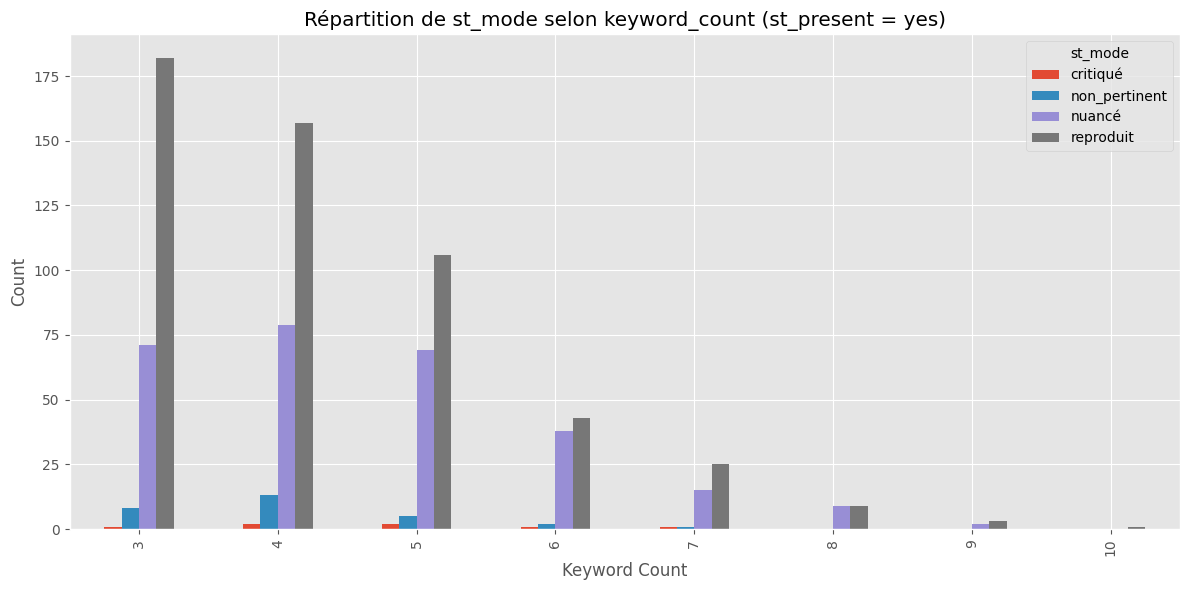

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Filter rows where st_present == "yes"
filtered = sr_ready[sr_ready["st_present"] == "yes"]

plt.style.use("ggplot")  # Using a matplotlib style as requested

# Create a pivot table for counts
pivot = filtered.pivot_table(
    index="keyword_count", columns="st_mode", aggfunc="size", fill_value=0
)

# Plot
pivot.plot(kind="bar", figsize=(12, 6))

plt.xlabel("Keyword Count")
plt.ylabel("Count")
plt.title("Répartition de st_mode selon keyword_count (st_present = yes)")
plt.tight_layout()

plt.show()


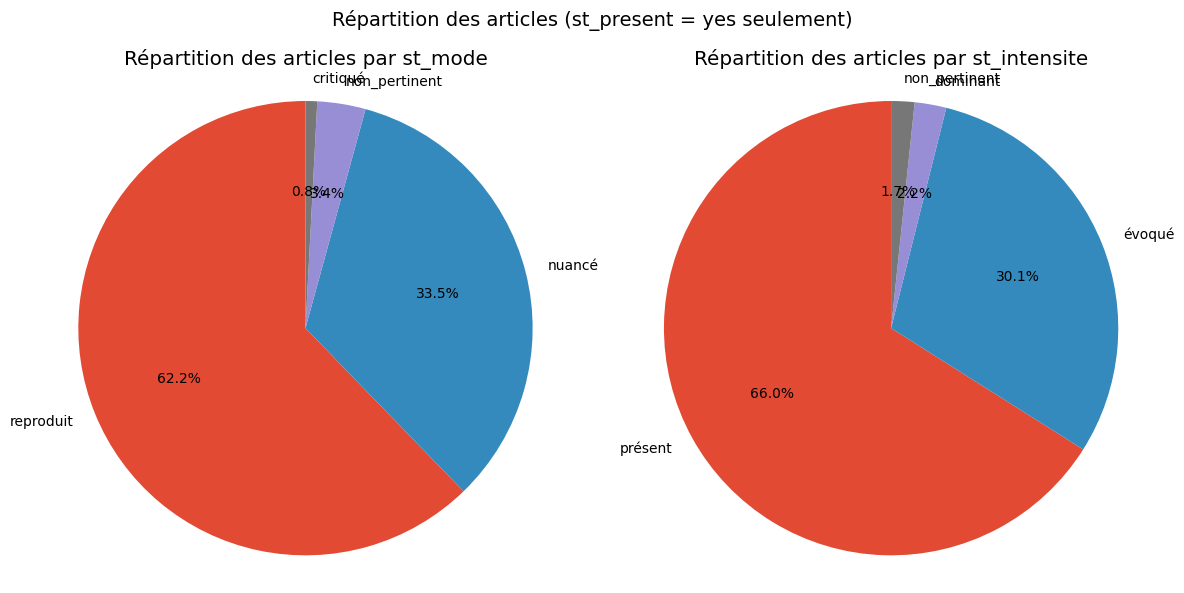

In [125]:
import matplotlib.pyplot as plt
import pandas as pd

# ===== Toggle here =====
# Set to True if you only want rows where st_present == "yes"
# Set to False to use ALL rows
filter_present = True
# =======================

if filter_present:
    df = sr_ready[sr_ready["st_present"] == "yes"].copy()
else:
    df = sr_ready.copy()

plt.style.use("ggplot")  # nice-looking style

# Prepare figure with two pie charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# ---- Pie chart for st_mode ----
mode_counts = df["st_mode"].value_counts()

axes[0].pie(mode_counts, labels=mode_counts.index, autopct="%1.1f%%", startangle=90)
axes[0].set_title("Répartition des articles par st_mode")
axes[0].axis("equal")  # make pie a circle

# ---- Pie chart for st_intensite ----
intensite_counts = df["st_intensite"].value_counts()

axes[1].pie(
    intensite_counts, labels=intensite_counts.index, autopct="%1.1f%%", startangle=90
)
axes[1].set_title("Répartition des articles par st_intensite")
axes[1].axis("equal")

# Overall title, with reminder of filter
filter_label = (
    " (st_present = yes seulement)" if filter_present else " (tous les articles)"
)
fig.suptitle("Répartition des articles" + filter_label, fontsize=14)

plt.tight_layout()
plt.show()


In [46]:
font = load_google_font("Libertinus Serif", danger_not_verify_ssl=True)
print(font)

sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:file=/home/artamis/.cache/pyfontsloader/bed376ccee8533f7b571bc0900cc0cabe1b01d49e723b77d1325da696a5262e0.ttf:size=10.0


In [49]:
def load_arctic_light_with_libertinus():
    """
    Return an aquarel Theme based on 'arctic_light'
    but using Google Fonts 'Libertinus Serif' as the
    default Matplotlib font (loaded via pyfonts).
    """
    # 1) Download & register the Libertinus Serif font from Google Fonts
    libertinus_fp = load_google_font("Libertinus Serif")
    libertinus_name = libertinus_fp.get_name()  # e.g. "Libertinus Serif"

    # 2) Start from the built-in arctic_light theme
    #    and override its font settings to use Libertinus
    theme = load_theme("arctic_light").set_font(
        family="serif",  # use the 'serif' family everywhere
        serif=[libertinus_name],  # and make that family be Libertinus Serif
    )

    # Optionally you can save it for reuse as a JSON theme:
    # theme.save("arctic_light_libertinus.json")

    return theme


In [50]:
theme = load_arctic_light_with_libertinus()
theme.apply()

findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
findfont: Generic family 'serif' not found because none of the following families were found: Libertinus Serif
f

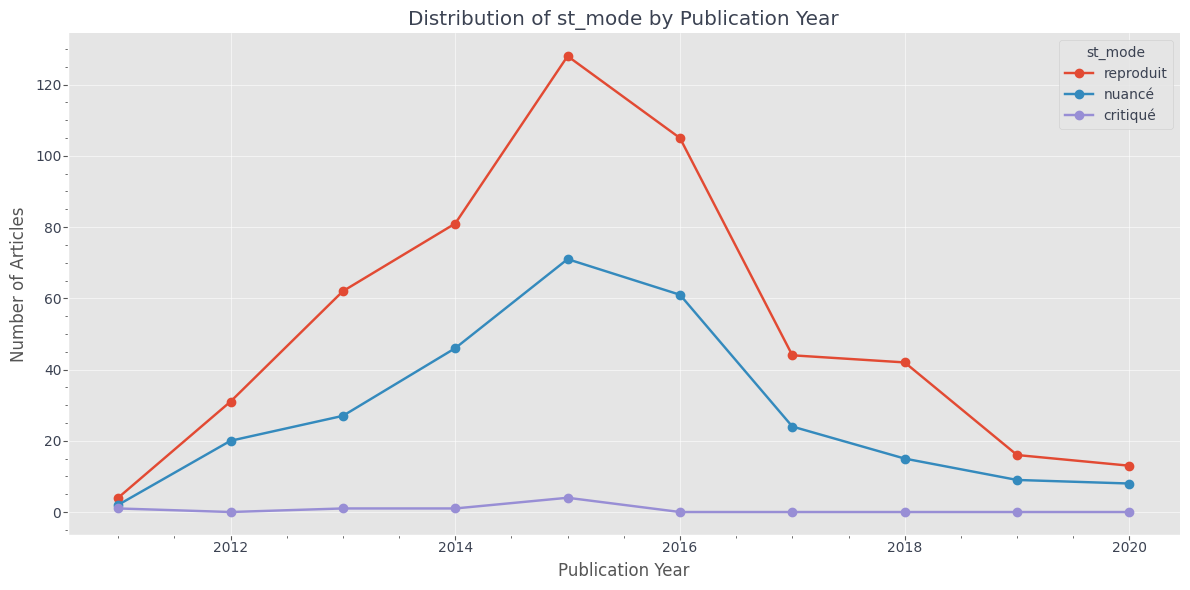

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure pub_date is datetime
sr_ready["pub_date"] = pd.to_datetime(sr_ready["pub_date"], errors="coerce")

# Extract publication year
sr_ready["pub_year"] = sr_ready["pub_date"].dt.year

# Keep only the 3 main st_mode categories
modes_to_keep = ["reproduit", "nuancé", "critiqué"]
df = sr_ready[sr_ready["st_mode"].isin(modes_to_keep)]

# Count rows per year & st_mode
counts = df.groupby(["pub_year", "st_mode"]).size().unstack(fill_value=0)

plt.style.use("ggplot")
plt.figure(figsize=(12, 6))

# Plot one curve per st_mode
for mode in modes_to_keep:
    if mode in counts.columns:
        plt.plot(counts.index, counts[mode], marker="o", label=mode)

plt.xlabel("Publication Year")
plt.ylabel("Number of Articles")
plt.title("Distribution of st_mode by Publication Year")
plt.legend(title="st_mode")
plt.tight_layout()
plt.show()


In [ ]:
sr_ready = combined_df.copy()
sr_ready.info()
# sr_ready = sr_ready[sr_ready["st_intensite"].isin(["évoqué"])]
# sr_ready = sr_ready[sr_ready["keyword_count"] >= 5]
sr_ready.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1922 entries, 0 to 1921
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 1922 non-null   int64 
 1   pub_date           1922 non-null   object
 2   feed               1922 non-null   object
 3   category           1922 non-null   object
 4   keyword            1904 non-null   object
 5   signature          1922 non-null   object
 6   title              1922 non-null   object
 7   text_html          1922 non-null   object
 8   text_cleaned       1922 non-null   object
 9   test_preprocessed  1922 non-null   object
 10  keyword_count      1922 non-null   int64 
 11  st_present         1922 non-null   object
 12  st_mode            1922 non-null   object
 13  st_intensite       1922 non-null   object
 14  st_resume          1922 non-null   object
 15  st_justification   1922 non-null   object
 16  st_raw_response    0 non-null      object


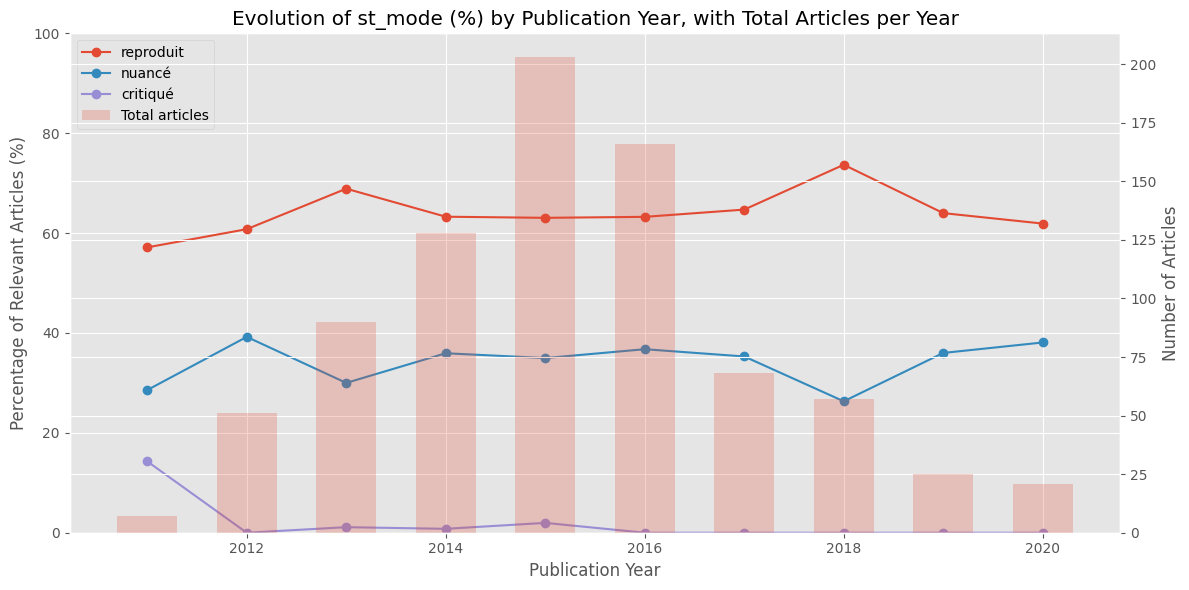

In [153]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure pub_date is datetime
sr_ready["pub_date"] = pd.to_datetime(sr_ready["pub_date"], errors="coerce")

# Extract publication year
sr_ready["pub_year"] = sr_ready["pub_date"].dt.year

# Keep only the 3 relevant st_mode categories
modes_to_keep = ["reproduit", "nuancé", "critiqué"]
df = sr_ready[sr_ready["st_mode"].isin(modes_to_keep)]

# Count articles per year and st_mode
counts = df.groupby(["pub_year", "st_mode"]).size().unstack(fill_value=0)

# Total relevant articles per year
totals = counts.sum(axis=1)

# Percentages per year
percentages = counts.div(totals, axis=0) * 100

plt.style.use("ggplot")
fig, ax1 = plt.subplots(figsize=(12, 6))

# ---- Percentage curves (left axis) ----
for mode in modes_to_keep:
    if mode in percentages.columns:
        ax1.plot(percentages.index, percentages[mode], marker="o", label=mode)

ax1.set_xlabel("Publication Year")
ax1.set_ylabel("Percentage of Relevant Articles (%)")
ax1.set_ylim(0, 100)

# ---- Bar chart for total articles (right axis) ----
ax2 = ax1.twinx()
ax2.bar(totals.index, totals.values, alpha=0.25, width=0.6, label="Total articles")
ax2.set_ylabel("Number of Articles")

# ---- Legends ----
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(
    lines_labels[0] + bars_labels[0], lines_labels[1] + bars_labels[1], loc="upper left"
)

plt.title("Evolution of st_mode (%) by Publication Year, with Total Articles per Year")
plt.tight_layout()
plt.show()


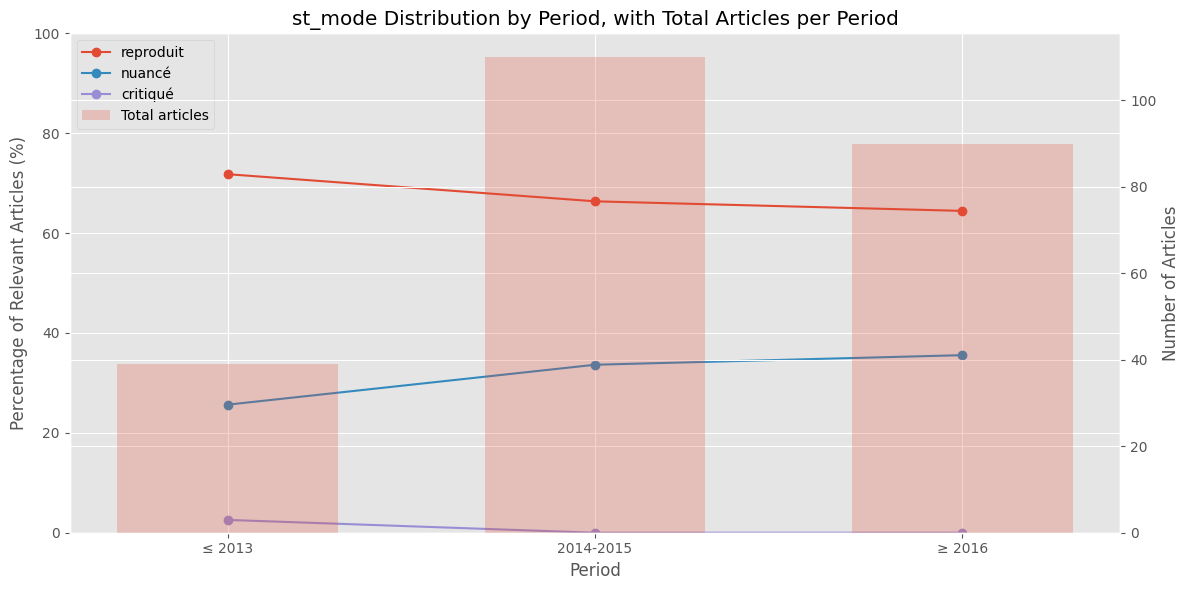

In [150]:
import matplotlib.pyplot as plt
import pandas as pd

# Make sure pub_date is datetime
sr_ready["pub_date"] = pd.to_datetime(sr_ready["pub_date"], errors="coerce")

# Extract publication year
sr_ready["pub_year"] = sr_ready["pub_date"].dt.year


# ----------------------------------------------------
# DEFINE PERIODS HERE — customize as you want
# ----------------------------------------------------
def year_to_period(year):
    if year <= 2013:
        return "≤ 2013"
    elif 2014 <= year <= 2015:
        return "2014-2015"
    else:
        return "≥ 2016"


sr_ready["period"] = sr_ready["pub_year"].apply(year_to_period)
# ----------------------------------------------------

# Keep only the 3 relevant st_mode categories
modes_to_keep = ["reproduit", "nuancé", "critiqué"]
df = sr_ready[sr_ready["st_mode"].isin(modes_to_keep)]

# Count articles per period and st_mode
counts = df.groupby(["period", "st_mode"]).size().unstack(fill_value=0)

# Total relevant articles per period
totals = counts.sum(axis=1)

# Percentages per period
percentages = counts.div(totals, axis=0) * 100

# Ensure periods appear in correct chronological order
period_order = ["≤ 2013", "2014-2015", "≥ 2016"]
percentages = percentages.reindex(period_order)
totals = totals.reindex(period_order)

plt.style.use("ggplot")
fig, ax1 = plt.subplots(figsize=(12, 6))

# ---- Percentage curves (left axis) ----
for mode in modes_to_keep:
    if mode in percentages.columns:
        ax1.plot(percentages.index, percentages[mode], marker="o", label=mode)

ax1.set_xlabel("Period")
ax1.set_ylabel("Percentage of Relevant Articles (%)")
ax1.set_ylim(0, 100)

# ---- Bar chart for total articles (right axis) ----
ax2 = ax1.twinx()
ax2.bar(totals.index, totals.values, alpha=0.25, width=0.6, label="Total articles")
ax2.set_ylabel("Number of Articles")

# ---- Legends ----
lines_labels = ax1.get_legend_handles_labels()
bars_labels = ax2.get_legend_handles_labels()
ax1.legend(
    lines_labels[0] + bars_labels[0], lines_labels[1] + bars_labels[1], loc="upper left"
)

plt.title("st_mode Distribution by Period, with Total Articles per Period")
plt.tight_layout()
plt.show()


In [151]:
# Filter articles with st_mode = "critiqué"
critique_df = sr_ready[sr_ready["st_mode"] == "nuancé"]

print(critique_df)

# Pretty print the relevant columns
for idx, row in critique_df.iterrows():
    print("──────────────────────────────────────────────")
    print(f"TITLE:\n{row['title']}\n")
    print(f"RÉSUMÉ:\n{row['st_resume']}\n")
    print(f"JUSTIFICATION:\n{row['st_justification']}\n")


            id            pub_date      feed category       keyword  \
92     9165825 2015-12-16 09:39:46  RTBFINFO    MONDE        EUROPE   
122    8155070 2013-12-11 11:01:00  RTBFINFO    MONDE  MOYEN ORIENT   
146    8363444 2014-09-25 08:02:00  RTBFINFO    MONDE  MOYEN ORIENT   
147    9627864 2017-06-07 20:46:22  RTBFINFO    MONDE  MOYEN ORIENT   
158    8390677 2014-10-31 08:01:00  RTBFINFO    MONDE  MOYEN ORIENT   
...        ...                 ...       ...      ...           ...   
1846  10341506 2019-10-14 21:49:00  RTBFINFO    MONDE  MOYEN ORIENT   
1888   9110001 2015-10-16 14:51:00  RTBFINFO    MONDE        DIVERS   
1893   9166893 2015-12-17 11:50:00  RTBFINFO    MONDE        EUROPE   
1913  10400956 2020-01-06 20:28:00  RTBFINFO    MONDE  MOYEN ORIENT   
1915  10429908 2020-02-11 09:02:06  RTBFINFO    MONDE        DIVERS   

                  signature  \
92                      AFP   
122          Wahoub Fayoumi   
146   Jean-François Herbecq   
147                    

In [85]:
print(sr_ready.iloc[0]["title"])
print(sr_ready.iloc[0]["st_resume"])
print(sr_ready.iloc[0]["st_justification"])

Liban: journée de deuil national après l'attentat de l'EI ayant fait 43 morts
L'article traite d'un attentat au Liban revendiqué par l'EI, lié au conflit syrien. Le Hezbollah est mentionné pour son soutien au régime de Bachar al-Assad contre les rebelles et les djihadistes en Syrie.
L'article reproduit l'idée reçue en mentionnant que le Hezbollah combat en Syrie aux côtés du régime de Bachar al-Assad contre les djihadistes, impliquant que sans ce soutien, la situation serait pire. Cela efface la diversité des acteurs et la complexité du conflit syrien.


In [17]:
import json
import re
from typing import Any, Dict, List

import requests

OLLAMA_URL = "http://localhost:11434/api/generate"
MODEL_NAME = "mistral:7b"  # or "llama3:8b", "mistral", etc.

In [18]:
stereotype_id = "assad_vs_daech"
stereotype = stereotypes[stereotype_id]

In [ ]:
def analyze_chunk_with_ollama(
    text: str,
    stereotype_id: str,
    stereotype: Dict[str, Any],
    model: str = MODEL_NAME,
    url: str = OLLAMA_URL,
    temperature: float = 0.1,
    timeout: int = 120,
) -> Dict[str, Any]:
    prompt = build_prompt_for_chunk(text, stereotype_id, stereotype)

    payload = {
        "model": model,
        "prompt": prompt,
        "format": "json",  # on demande du JSON directement
        "stream": False,
        "options": {"temperature": temperature},
    }

    resp = requests.post(url, json=payload, timeout=timeout)
    resp.raise_for_status()

    raw_response = resp.json().get("response", "").strip()

    try:
        data = json.loads(raw_response)
    except json.JSONDecodeError:
        data = {"error": "json_decode_error", "raw": raw_response}

    return data


In [ ]:
def analyze_issue_for_stereotype_focus(
    full_text: str,
    stereotype_id: str,
    stereotype: Dict[str, Any],
) -> Dict[str, Any]:
    """
    Analyse un journal (texte complet) pour un stéréotype donné,
    en ne sélectionnant qu'un chunk "focal" autour des mots-clés.

    Retourne :
    - score_presence (ou 0.0 si pas de résultat)
    - mode
    - le chunk utilisé, pour inspection
    - le résultat brut du LLM
    """
    focus_chunk = full_text

    if not focus_chunk.strip():
        return {
            "stereotype_id": stereotype_id,
            "score_presence": 0.0,
            "mode": "non_pertinent",
            "chunk": "",
            "llm_result": None,
        }

    res = analyze_chunk_with_ollama(focus_chunk, stereotype_id, stereotype)

    if isinstance(res, dict) and "score_presence" in res and not res.get("error"):
        return {
            "stereotype_id": stereotype_id,
            "score_presence": res.get("score_presence", 0.0),
            "mode": res.get("mode", "non_pertinent"),
            "chunk": focus_chunk,
            "llm_result": res,
        }
    else:
        return {
            "stereotype_id": stereotype_id,
            "score_presence": 0.0,
            "mode": "non_pertinent",
            "chunk": focus_chunk,
            "llm_result": res,
        }


In [ ]:
stereotype_id = "assad_vs_daech"
stereotype = stereotypes[stereotype_id]


def analyze_row_focus(row):
    text = row["text_cleaned"]
    return analyze_issue_for_stereotype_focus(
        full_text=text,
        stereotype_id=stereotype_id,
        stereotype=stereotype,
    )


sr_keywords["llm_assad_vs_daech"] = sr_keywords.progress_apply(
    analyze_row_focus, axis=1
)

  0%|          | 0/57 [00:00<?, ?it/s]

/tmp/ipykernel_9990/741118110.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["llm_assad_vs_daech"] = sr_keywords.progress_apply(analyze_row_focus, axis=1)


In [50]:
sr_keywords["assad_vs_daech_score"] = sr_keywords["llm_assad_vs_daech"].apply(
    lambda d: d.get("score_presence", 0.0) if isinstance(d, dict) else 0.0
)

sr_keywords["assad_vs_daech_mode"] = sr_keywords["llm_assad_vs_daech"].apply(
    lambda d: d.get("mode", "non_pertinent") if isinstance(d, dict) else "non_pertinent"
)

/tmp/ipykernel_9990/2000915364.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["assad_vs_daech_score"] = sr_keywords["llm_assad_vs_daech"].apply(
/tmp/ipykernel_9990/2000915364.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sr_keywords["assad_vs_daech_mode"] = sr_keywords["llm_assad_vs_daech"].apply(


In [ ]:
sr_assad = sr_keywords.sort_values(by=["assad_vs_daech_score"], ascending=False)

In [67]:
sr_assad.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57 entries, 516794 to 706107
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    57 non-null     int64         
 1   pub_date              57 non-null     datetime64[ns]
 2   feed                  57 non-null     object        
 3   category              57 non-null     object        
 4   keyword               55 non-null     object        
 5   signature             57 non-null     object        
 6   title                 57 non-null     object        
 7   text_html             57 non-null     object        
 8   text_cleaned          57 non-null     object        
 9   test_preprocessed     57 non-null     object        
 10  keyword_count         57 non-null     int64         
 11  llm_assad_vs_daech    57 non-null     object        
 12  assad_vs_daech_score  57 non-null     float64       
 13  assad_vs_daech_mod

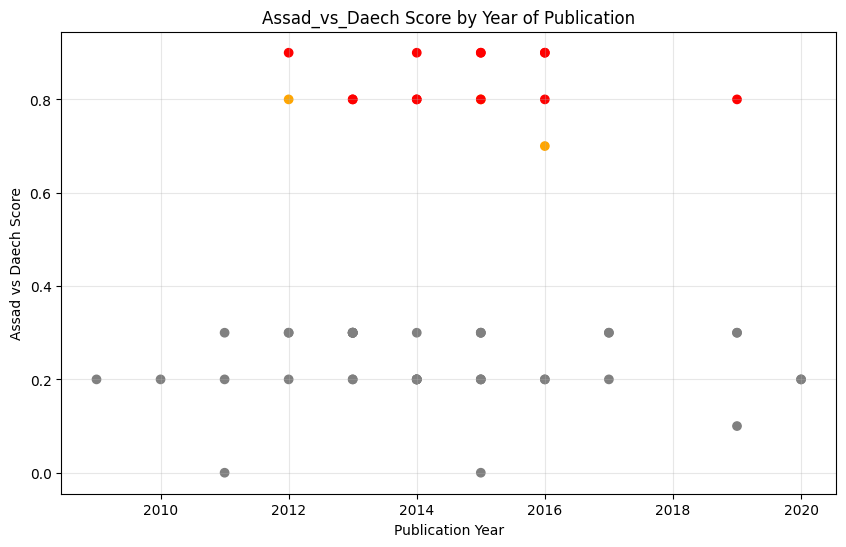

In [ ]:
import matplotlib.pyplot as plt

# Extract publication year
sr_assad["year"] = sr_assad["pub_date"].dt.year

# Color mapping
color_map = {
    "reproduit": "red",
    "nuancé": "orange",
    "critiqué": "green",
    "non_pertinent": "grey",
}

# Assign colors based on the mode
colors = sr_assad["assad_vs_daech_mode"].map(color_map)

# Create scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(sr_assad["year"], sr_assad["assad_vs_daech_score"], c=colors)

plt.xlabel("Publication Year")
plt.ylabel("Assad vs Daech Score")
plt.title("Assad_vs_Daech Score by Year of Publication")

# Optional: show grid
plt.grid(True, alpha=0.3)

plt.show()


In [77]:
sr_keywords.loc[sr_keywords["assad_vs_daech_mode"] == "nuancé"]["text_cleaned"].iloc[0]

'La coalition internationale antidjihadistes menée par les Etats-Unis a admis samedi avoir bombardé ce qu\'elle pensait être une position du groupe Etat islamique (EI) en Syrie, tuant au moins 60 soldats syriens et provoquant une réunion du Conseil de sécurité de l\'ONU.\n\nLes Etats-Unis ont exprimé samedi leurs "regrets" à la Russie, a dit un responsable de l\'administration Obama. Les Etats-Unis vont continuer d\'observer la trêve en vigueur en Syrie tout en poursuivant leurs opérations militaires contre l\'organisation Etat islamique et Al Qaïda, écrit ce responsable dans un courriel.\n\nUne trêve mise à mal\n\nCe bombardement meurtrier est intervenu au cinquième jour d\'une fragile trêve issue d\'un accord entre les Etats-Unis et la Russie. Dans la foulée, Moscou a accusé samedi soir l\'"opposition modérée" syrienne, soutenue par les Etats-Unis, d\'avoir "fait échouer" ce cessez-le-feu.\n\nCette trêve avait déjà été mise à mal vendredi avec de violents combats et des civils tués d